In [21]:
import collections
import torch
import torch.nn as nn
from numpy import mean
import torch
import torch.nn as nn
import torch.nn.functional as F

import glob
import os 
import string
from pathlib import Path

from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import resnet18, resnet34, resnet50, resnet101, resnet152, vgg11
from torchvision import models
from torchsummary import summary
import matplotlib.pyplot as plt
from IPython.display import clear_output
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import time
from itertools import product

%matplotlib inline
plt.style.use('seaborn')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
file_path = 'drive/MyDrive'

In [23]:
class strLabelConverter(object):
    """Convert between str and label.
        Insert `blank` to the alphabet for CTC. 
    Args:
        alphabet (str): set of the possible characters.
        ignore_case (bool, default=True): whether or not to ignore all of the case.
    """

    def __init__(self, alphabet: str, ignore_case: bool = True):
        self._ignore_case = ignore_case
        if self._ignore_case:
            alphabet = alphabet.lower()
        self.alphabet = alphabet + '-'                                     # for `-1` index. Se añade un '-' al final.

        self.char2idx = {}
        for i, char in enumerate(alphabet):
                                                                           # NOTE: 0 is reserved for 'blank' required by wrap_ctc
            self.char2idx[char] = i + 1                                    #Diccionario. Llave: letra, valor: indice único.
        self.idx2char = {idx: char for char, idx in self.char2idx.items()} #Se voltea llave por valor del diccionario anterior.

    def encode(self, text):
        """Support batch or single str.
        Args:
            text (str or list of str): texts to convert.
        Returns:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.
        """
        if isinstance(text, str):
            text = [
                self.char2idx[char.lower() if self._ignore_case else char]
                for char in text
            ]                                                   #Mapeo de alguna palabra (sin espacio) a índice único.
            length = [len(text)]
        elif isinstance(text, collections.Iterable):
            length = [len(s) for s in text]                     #Obtiene la longitud de cada palabra en el arreglo.
            text = ''.join(text)                                #Concatena las palabras (sin espacio).
            text, _ = self.encode(text)
        return (torch.IntTensor(text), torch.IntTensor(length)) #Lista con tensor de las representaciones numéricas del texto y sus longitudes correspondientes.

    def decode(self, t, length, raw=False):
        """Decode encoded texts back into strs.
        Args:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.
        Raises:
            AssertionError: when the texts and its length does not match.
        Returns:
            text (str or list of str): texts to convert.
        """
        if length.numel() == 1:                                   # Si es una sola palabra. Nota: .numel() te da el número total de elementos del tensor
            length = length[0]                                    #Extrae la longitud de la palbra
            assert t.numel() == length, "text with length: {} does not match declared length: {}".format(t.numel(), length)
            if raw:
                return ''.join([self.alphabet[i - 1] for i in t]) #Convierte números a palabra
            else:
                char_list = []
                for i in range(length):
                    if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
                        char_list.append(self.alphabet[t[i] - 1])
                return ''.join(char_list)                         #Convierte números a palabra
        else:
            # batch mode
            assert t.numel() == length.sum(), "texts with length: {} does not match declared length: {}".format(t.numel(), length.sum())
            texts = []
            index = 0
            for i in range(length.numel()):
                l = length[i]
                texts.append(
                    self.decode(
                        t[index:index + l], torch.IntTensor([l]), raw=raw))
                index += l
        return texts                                              #Convierte números a palabra (caso de lotes)


def decode_prediction(logits: torch.Tensor, 
                      label_converter: strLabelConverter) -> str:
    tokens = logits.softmax(2).argmax(2)
    tokens = tokens.squeeze(1).numpy()
    
    # convert tor stings tokens
    tokens = ''.join([label_converter.idx2char[token] 
                      if token != 0  else '-' 
                      for token in tokens])
    tokens = tokens.split('-')
    
    # remove duplicates
    text = [char 
            for batch_token in tokens 
            for idx, char in enumerate(batch_token)
            if char != batch_token[idx-1] or len(batch_token) == 1]
    text = ''.join(text)
    return text

def plot_loss(epoch: int, 
              train_losses: list, 
              val_losses: list, 
              n_steps: int = 100):
    """
    Plots train and validation losses 
    """
    # clear previous graph
    clear_output(True)
    # making titles
    train_title = f'Epoch:{epoch} | Train Loss:{np.mean(train_losses[-n_steps:]):.6f}'
    val_title = f'Epoch:{epoch} | Val Loss:{np.mean(val_losses[-n_steps:]):.6f}'

    fig = make_subplots(rows=1, cols=2)
    fig.add_trace(go.Scatter(y=train_losses,mode='lines',name=train_title),row=1, col=1)
    fig.add_trace(go.Scatter(y=val_losses,mode='lines',name=val_title),row=1, col=2)
    fig.update_layout(title_text='Funciones de pérdida',title_x=0.5)
    #fig.show()
    return fig


def print_prediction(model, dataset, device, label_converter):
    idx = np.random.randint(len(dataset))
    path = dataset.pathes[idx]
    
    with torch.no_grad():
        model.eval()
        img, target_text = dataset[idx]
        img = img.unsqueeze(0)
        logits = model(img.to(device))
        
    pred_text = decode_prediction(logits.cpu(), label_converter)

    img = np.asarray(Image.open(path).convert('L'))
    title = f'Truth: {target_text} | Pred: {pred_text}'
    plt.imshow(img)
    plt.title(title)
    plt.axis('off');
    
class blockCNN(nn.Module):
    def __init__(self, in_nc, out_nc, kernel_size, padding, stride=1):
        super(blockCNN, self).__init__()
        self.in_nc = in_nc
        self.out_nc = out_nc
        self.kernel_size = kernel_size
        self.padding = padding
        # layers
        self.conv = nn.Conv2d(in_nc, out_nc, 
                              kernel_size=kernel_size, 
                              stride=stride, 
                              padding=padding)
        self.bn = nn.BatchNorm2d(out_nc)
        
    def forward(self, batch, use_bn=False, use_relu=False, 
                use_maxpool=False, maxpool_kernelsize=None):
        """
            in:
                batch - [batch_size, in_nc, H, W]
            out:
                batch - [batch_size, out_nc, H', W']
        """
        batch = self.conv(batch)
        if use_bn:
            batch = self.bn(batch)
        if use_relu:
            batch = F.relu(batch)
        if use_maxpool:
            assert maxpool_kernelsize is not None
            batch = F.max_pool2d(batch, kernel_size=maxpool_kernelsize, stride=2)
        return batch

class blockRNN(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, bidirectional, dropout=0):
        super(blockRNN, self).__init__()
        self.in_size = in_size
        self.hidden_size = hidden_size
        self.out_size = out_size
        self.bidirectional = bidirectional
        # layers
        self.gru = nn.GRU(in_size, hidden_size, bidirectional=bidirectional)
        
    def forward(self, batch, add_output=False):
        """
        in array:
            batch - [seq_len , batch_size, in_size]
        out array:
            out - [seq_len , batch_size, out_size]
        """
        batch_size = batch.size(1)
        outputs, hidden = self.gru(batch)
        out_size = int(outputs.size(2) / 2)
        if add_output:
            outputs = outputs[:, :, :out_size] + outputs[:, :, out_size:]
        return outputs

class CaptchaDataset(Dataset):
    def __init__(self, img_dir: str):
        pathes = os.listdir(img_dir)                                       #Arreglo que contiene los nombres de las imágenes
        abspath = os.path.abspath(img_dir)                                 #Obtiene el path absoluto de las imágenes
        self.img_dir = img_dir
        self.pathes = [os.path.join(abspath, path) for path in pathes]     #Arreglo que contiene el full path de la imágen (al final tiene el .png)
        self.list_transforms = transforms.Compose([transforms.ToTensor()]) #.ToTensor(). Convierte la imagen de entrada a Pytorch Tensor. .Compose()
                                                                           #Compone los tensores de imágenes
        
    def __len__(self):
        return len(self.pathes)                                            #Longitud del vector de imágenes (# de imágenes cargadas)
    
    def __getitem__(self, idx):
        path = self.pathes[idx]
        text = self.get_filename(path)
        img = Image.open(path).convert('RGB')
        img = self.transform(img)
        return img, text
    
    def get_filename(self, path: str) -> str:
        return os.path.basename(path).split('.')[0].lower().strip()
    
    def transform(self, img) -> torch.Tensor:
        return self.list_transforms(img)


class CRNN(nn.Module):
    def __init__(self, hidden_size: int, 
                 vocab_size: int,
                 pretrain_model: str, 
                 bidirectional: bool = True, 
                 dropout: float = 0.5):
      
        super(CRNN, self).__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.bidirectional = bidirectional
        self.pretrain_model = pretrain_model
        # make layers
        # convolutions

        if self.pretrain_model=='res_net18':
          resnet = resnet18(pretrained=True)
          modules = list(resnet.children())[:-3]
        elif self.pretrain_model=='res_net34':
          resnet = resnet34(pretrained=True)
          modules = list(resnet.children())[:-3]
        
        self.resnet = nn.Sequential(*modules)      

        self.cn6 = blockCNN(256, 256, kernel_size=3, padding=1)
        # RNN + Linear
        self.linear1 = nn.Linear(1024, 256)
        self.gru1 = blockRNN(256, hidden_size, hidden_size,
                             dropout=dropout, 
                             bidirectional=bidirectional)
        self.gru2 = blockRNN(hidden_size, hidden_size, vocab_size,
                             dropout=dropout,
                             bidirectional=bidirectional)
        self.linear2 = nn.Linear(hidden_size * 2, vocab_size)
        
    def forward(self, batch: torch.Tensor):
        """
        ------:size sequence:------
        torch.Size([batch_size, 3, 50, 200]) -- IN:
        torch.Size([batch_size, 256, 4, 13]) -- CNN blocks ended
        torch.Size([batch_size, 13, 256, 4]) -- permuted 
        torch.Size([batch_size, 13, 1024]) -- Linear #1
        torch.Size([batch_size, 13, 256]) -- IN GRU 
        torch.Size([batch_size, 13, 256]) -- OUT GRU 
        torch.Size([batch_size, 13, vocab_size]) -- Linear #2
        torch.Size([13, batch_size, vocab_size]) -- :OUT
        """
        batch_size = batch.size(0)
        # convolutions
        batch = self.resnet(batch)
        batch = self.cn6(batch, use_relu=True, use_bn=True)
        # make sequences of image features
        batch = batch.permute(0, 3, 1, 2)
        n_channels = batch.size(1)
        batch = batch.view(batch_size, n_channels, -1)
        batch = self.linear1(batch)
        # rnn layers
        batch = self.gru1(batch, add_output=True)
        batch = self.gru2(batch)
        # output
        batch = self.linear2(batch)
        batch = batch.permute(1, 0, 2)
        return batch

def acc_calc(model, dataset, label_converter) -> float:
    acc = 0
    with torch.no_grad():
        model.eval()
        for idx in range(len(dataset)):
            img, text = dataset[idx]
            logits = model(img.unsqueeze(0).to(device))
            pred_text = decode_prediction(logits.cpu(), label_converter)
            
            if pred_text == text:
                acc += 1

    accuracy = acc / len(dataset)
    accuracy = round(accuracy*100,2)        
    return accuracy

def jaccard_calc(model, dataset, label_converter) -> float:
    true_texts = []
    pred_texts = []
    with torch.no_grad():
        model.eval()
        for idx in range(len(dataset)):
            img, text = dataset[idx]
            logits = model(img.unsqueeze(0).to(device))
            pred_text = decode_prediction(logits.cpu(), label_converter)

            true_texts.append(text)
            pred_texts.append(pred_text)
            
    s1 = set(true_texts)
    s2 = set(pred_texts)
    jaccard_similarity = float(len(s1.intersection(s2)) / len(s1.union(s2)))
    jaccard_similarity = round(jaccard_similarity*100,2)
    return jaccard_similarity

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

TRAIN_DIR = Path(file_path+'/data/train')
VAL_DIR = Path(file_path+'/data/val')
OWN_DIR = Path(file_path+'/data/own')
BATCH_SIZE = 8
MODEL_PATH = Path(file_path+'/models/crnn.pt')
N_WORKERS = 2

alphabet = string.ascii_lowercase + string.digits
label_converter = strLabelConverter(alphabet)

train_dataset = CaptchaDataset(TRAIN_DIR)
val_dataset = CaptchaDataset(VAL_DIR)
own_dataset = CaptchaDataset(OWN_DIR)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                              num_workers=N_WORKERS, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, 
                            num_workers=N_WORKERS, shuffle=False)

imgs, texts = iter(val_dataloader).next()
#print(imgs.shape, len(texts))
critertion = nn.CTCLoss(blank=0)

In [25]:
def train(pretrain_model_value, optimizer_name, dropout_value, lr_value):

  def validation(model, val_losses, label_converter):
    with torch.no_grad():
        model.eval()
        for batch_img, batch_text in val_dataloader:
            logits = crnn(batch_img.to(device))
            val_loss = calculate_loss(logits, batch_text, label_converter)
            val_losses.append(val_loss.item())
    return val_losses

  def calculate_loss(logits, texts, label_converter):
      # get infomation from prediction
      device = logits.device
      input_len, batch_size, vocab_size = logits.size()
      # encode inputs
      logits = logits.log_softmax(2)
      encoded_texts, text_lens = label_converter.encode(texts)
      logits_lens = torch.full(size=(batch_size,), fill_value=input_len, dtype=torch.int32)
      # calculate ctc
      loss = critertion(logits, encoded_texts, 
                        logits_lens.to(device), text_lens)
      return loss

  hidden_size = 256
  vocab_size = len(alphabet) + 1 # extra character for blank symbol
  bidirectional = True
  dropout = dropout_value
  weight_decay = 1e-5
  momentum = 0.9
  clip_norm = 5
  max_epoch = 50
  lr = lr_value
  #print(vocab_size)

  crnn = CRNN(hidden_size=hidden_size, vocab_size=vocab_size, bidirectional=bidirectional, dropout=dropout, 
              pretrain_model=pretrain_model_value).to(device)
  #crnn(imgs.to(device)).shape

  if optimizer_name == 'SGD': 
    optimizer = torch.optim.SGD(crnn.parameters(), lr=lr, nesterov=True, 
                                weight_decay=weight_decay, momentum=momentum)
  elif optimizer_name == 'AdaDelta':
    optimizer = torch.optim.Adadelta(crnn.parameters(), lr=lr, weight_decay=weight_decay)

  critertion = nn.CTCLoss(blank=0)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5)

  epoch = 0
  train_losses = []
  val_losses = []
  val_epoch_len = len(val_dataset) // BATCH_SIZE
  #val_epoch_len

  try:
      while epoch <= max_epoch:
          crnn.train()
          for idx, (batch_imgs, batch_text) in enumerate(train_dataloader):
              optimizer.zero_grad()
              logits = crnn(batch_imgs.to(device))
              # calculate loss
              train_loss = calculate_loss(logits, batch_text, label_converter)
              if np.isnan(train_loss.detach().cpu().numpy()):
                  continue
              train_losses.append(train_loss.item())
              # make backward
              train_loss.backward()

              nn.utils.clip_grad_norm_(crnn.parameters(), clip_norm)
              optimizer.step()

          val_losses = validation(crnn, val_losses, label_converter)
          
          # printing progress
          fig_loss = plot_loss(epoch, train_losses, val_losses)
          #print_prediction(crnn, val_dataset, device, label_converter)
          
          scheduler.step(val_losses[-1])
          epoch += 1
  except KeyboardInterrupt:
      pass

  # saving model
  #torch.save(crnn.state_dict(), MODEL_PATH)

  val_acc = acc_calc(crnn, val_dataset, label_converter)
  train_acc = acc_calc(crnn, train_dataset, label_converter)
  val_jacc = jaccard_calc(crnn, val_dataset, label_converter)
  train_jacc = jaccard_calc(crnn, train_dataset, label_converter)

  return crnn,fig_loss,train_acc,val_acc,train_jacc,val_jacc

In [ ]:
%%time
np.random.seed(42)

#Proof
pretrain_models=['res_net18']
optimizers=['SGD']
dropout_values=[0.75]
lr_values=[0.02, 0.05, 0.09]

#Full combinations
pretrain_models=['res_net18','res_net34']
optimizers=['SGD','AdaDelta']
dropout_values=[0.1,0.5,0.75]
lr_values=[0.02, 0.05, 0.09]

comb = list(product(pretrain_models,optimizers,dropout_values,lr_values))
df = pd.DataFrame(columns=['Modelo pre-entrenado','Optimizador','Tasa de aprendizaje','Valor Drop out','Precisión (entrenamiento)','Precisión (validación)',
                           'Indice Jaccard (entrenamiento)','Indice Jaccard (validación)','Tiempo de ejecución (s)'])
plots = {}
models = {}
for value in comb:
  start_time = time.time()
  model,fig_loss,x,y,w,z=train(pretrain_model_value=value[0], optimizer_name=value[1], dropout_value=value[2],
                               lr_value=value[3])
  #Save Figs
  plots[f'{value[0]}-{value[1]}-{value[2]}-{value[3]}'] = fig_loss
  models[f'{value[0]}-{value[1]}-{value[2]}-{value[3]}'] = model
  end_time= time.time()
  elapsed_time = end_time - start_time
  elapsed_time = round(elapsed_time,2)
  print(f'Listo: {value}')
  df.loc[len(df)]=(value[0],value[1],value[3],value[2],x,y,w,z,elapsed_time)

In [ ]:
df

,Modelo pre-entrenado,Optimizador,Tasa de aprendizaje,Valor Drop out,Precisión (entrenamiento),Precisión (validación),Indice Jaccard (entrenamiento),Indice Jaccard (validación),Tiempo de ejecución (s)
0,res_net18,SGD,0.02,0.10,92.76,79.91,86.49,66.54,180.42
1,res_net18,SGD,0.05,0.10,90.19,79.44,82.13,65.89,181.70
2,res_net18,SGD,0.09,0.10,89.37,85.05,80.78,73.98,180.36
3,res_net18,SGD,0.02,0.50,80.96,71.50,68.01,55.64,180.11
4,res_net18,SGD,0.05,0.50,89.14,78.50,80.40,64.62,179.82
5,res_net18,SGD,0.09,0.50,88.55,79.44,79.45,65.89,180.83
6,res_net18,SGD,0.02,0.75,90.42,73.36,82.52,57.93,181.88
7,res_net18,SGD,0.05,0.75,87.85,80.37,78.33,67.19,181.85
8,res_net18,SGD,0.09,0.75,0.00,0.00,0.00,0.00,184.45
9,res_net18,AdaDelta,0.02,0.10,95.33,63.55,91.07,46.58,201.57


In [ ]:
df.to_csv(file_path+'/data/results.csv',index=False)

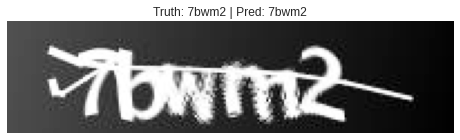

In [ ]:
print_prediction(models['res_net18-SGD-0.75-0.05'], val_dataset, device, label_converter)

In [ ]:
df=pd.read_csv(file_path+'/data/results.csv')

In [ ]:
#Best models
best_models = df.sort_values(by=['Precisión (validación)','Indice Jaccard (validación)'],ascending=False).reset_index(drop=True).head(5)
best_models['Nombre'] = ['Experimento 1','Experimento 2', 'Experimento 3', 'Experimento 4', 'Experimento 5']
baseline_model = df.loc[(df['Modelo pre-entrenado']=='res_net18')&(df['Optimizador']=='SGD')&(df['Valor Drop out']==0.1)&(df['Tasa de aprendizaje']==0.02)]
baseline_model['Nombre'] = ['Baseline']
models = pd.concat([baseline_model,best_models],ignore_index=True)
models = models.sort_values(by=['Precisión (validación)','Indice Jaccard (validación)'],ascending=False).reset_index(drop=True)
models = models[['Nombre', 'Modelo pre-entrenado', 'Optimizador', 'Tasa de aprendizaje','Valor Drop out', 'Precisión (entrenamiento)', 
          'Precisión (validación)','Indice Jaccard (entrenamiento)', 'Indice Jaccard (validación)','Tiempo de ejecución (s)']]

fig = go.Figure(data=[go.Table(
    header=dict(values=list(models.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[models[cols] for cols in models.columns],
               fill_color='lavender',
               align='left'))
])

fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
fig = go.Figure(data=[
    go.Bar(name='Indice Jaccard (entrenamiento)', x=models['Nombre'], y=models['Indice Jaccard (entrenamiento)'], text=models['Precisión (entrenamiento)'], textposition='outside'),
    go.Scatter(name='Precisión (entrenamiento)', x=models['Nombre'], y=models['Precisión (entrenamiento)']),
    go.Bar(name='Indice Jaccard (validación)', x=models['Nombre'], y=models['Indice Jaccard (validación)'], text=models['Precisión (validación)'], textposition='outside'),
    go.Scatter(name='Precisión (validación)', x=models['Nombre'], y=models['Precisión (validación)'])
])
fig.update_layout(title = 'Desempeño del modelo con diferentes arquitecturas', title_x=0.5)
fig.show()

In [ ]:
pretrain=models['Modelo pre-entrenado']
op=models['Optimizador']
drop=models['Valor Drop out']
lrs=models['Tasa de aprendizaje']

comb = []
for i in range(6):
  comb.append([pretrain[i], op[i], drop[i], lrs[i]])

In [ ]:
%%time
np.random.seed(42)
plots = {}
models = {}
for value in comb:
  start_time = time.time()
  model,fig_loss,x,y,w,z=train(pretrain_model_value=value[0], optimizer_name=value[1], dropout_value=value[2],
                               lr_value=value[3])
  #Save Figs
  plots[f'{value[0]}-{value[1]}-{value[2]}-{value[3]}'] = fig_loss
  models[f'{value[0]}-{value[1]}-{value[2]}-{value[3]}'] = model

CPU times: user 15min 42s, sys: 1min 18s, total: 17min 1s
Wall time: 20min 30s


In [ ]:
models.keys()

dict_keys(['res_net34-AdaDelta-0.1-0.09', 'res_net34-AdaDelta-0.5-0.09', 'res_net18-SGD-0.1-0.09', 'res_net18-AdaDelta-0.5-0.09', 'res_net18-AdaDelta-0.75-0.09', 'res_net18-SGD-0.1-0.02'])

None

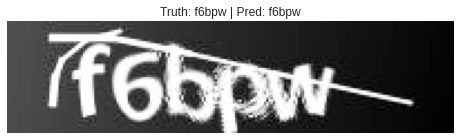

In [ ]:
display(print_prediction(models['res_net34-AdaDelta-0.1-0.09'], own_dataset, device, label_converter))

None

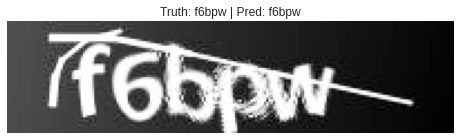

In [ ]:
display(print_prediction(models['res_net18-SGD-0.1-0.02'], own_dataset, device, label_converter))

In [ ]:
for key in plots.keys():
  print(key)
  display(plots[key])

res_net34-AdaDelta-0.1-0.09


res_net34-AdaDelta-0.5-0.09


res_net18-SGD-0.1-0.09


res_net18-AdaDelta-0.5-0.09


res_net18-AdaDelta-0.75-0.09


res_net18-SGD-0.1-0.02


In [ ]:
pretrain_models=['res_net18','res_net34']
optimizers=['SGD','AdaDelta']
dropout_values=[0.1,0.5,0.75]
lr_values=[0.02, 0.05, 0.09]

df1 = pd.DataFrame(dict(zip(['Baseline','Propuesta'], pretrain_models)), index=['Modelo pre-entrenado'])
df2 = pd.DataFrame(dict(zip(['Baseline','Propuesta'], optimizers)), index=['Optimizador'])
arq = pd.concat([df1,df2]).reset_index(drop=False).rename(columns={'index':'Componente'})

fig = go.Figure(data=[go.Table(
    header=dict(values=list(arq.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[arq[cols] for cols in arq.columns],
               fill_color='lavender',
               align='left'))
])

fig.show()

In [ ]:

df3 = pd.DataFrame(dict(zip(['Baseline','Propuesta 1', 'Propuesta 2'], dropout_values)), index=['Tasa Drop out'])
df4 = pd.DataFrame(dict(zip(['Baseline','Propuesta 1', 'Propuesta 2'], lr_values)), index=['Tasa de aprendizaje'])
hip = pd.concat([df3,df4]).reset_index(drop=False).rename(columns={'index':'Hiper parámetro'})

display(hip)
fig = go.Figure(data=[go.Table(columnwidth = [5,10,10,10],
    header=dict(values=list(hip.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[hip[cols] for cols in hip.columns],
               fill_color='lavender',
               align='left'))
])

fig.show()

,Hiper parámetro,Baseline,Propuesta 1,Propuesta 2
0,Tasa Drop out,0.10,0.50,0.75
1,Tasa de aprendizaje,0.02,0.05,0.09


In [27]:
#Full combinations
pretrain_models=['res_net34']
optimizers=['AdaDelta']
dropout_values=[0.1]
lr_values=[0.09]

comb = list(product(pretrain_models,optimizers,dropout_values,lr_values))
df = pd.DataFrame(columns=['Modelo pre-entrenado','Optimizador','Tasa de aprendizaje','Valor Drop out','Precisión (entrenamiento)','Precisión (validación)',
                           'Indice Jaccard (entrenamiento)','Indice Jaccard (validación)','Tiempo de ejecución (s)'])
plots = {}
models = {}
for value in comb:
  start_time = time.time()
  model,fig_loss,x,y,w,z=train(pretrain_model_value=value[0], optimizer_name=value[1], dropout_value=value[2],
                               lr_value=value[3])
  #Save Figs
  plots[f'{value[0]}-{value[1]}-{value[2]}-{value[3]}'] = fig_loss
  models[f'{value[0]}-{value[1]}-{value[2]}-{value[3]}'] = model
  end_time= time.time()
  elapsed_time = end_time - start_time
  elapsed_time = round(elapsed_time,2)
  print(f'Listo: {value}')
  df.loc[len(df)]=(value[0],value[1],value[3],value[2],x,y,w,z,elapsed_time)

Listo: ('res_net34', 'AdaDelta', 0.1, 0.09)
